# [NTDS'18] milestone 4: graph signal processing
[ntds'18]: https://github.com/mdeff/ntds_2018

[Rodrigo Pena](https://people.epfl.ch/254838), [EPFL LTS2](http://lts2.epfl.ch)

## Students

* Team: 31
* Students: Dilara Günay, Derin Sinan Bursa, Othman Benchekroun, Sinan Gökçe
* Dataset: IMDb Films and Crew

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to do some Graph Signal Processing (GSP) on the data of your project.

### A note about plotting

There are several questions in this milestone that ask you to plot a signal on your network.
There are several ways from which you could approach it.
In all cases, compute the position of the nodes a single time at the beginning, as this is likely to be a costly operation.
Using a single layout for all the graph plots will also make it easier to compare the plots.
Indeed, the only thing changing between plots is the signal displayed.
You can represent the features/labels lying on the graph via node **colors**.
To do so, make sure to have a consistent color map throughout and remember to display a colorbar and scale in all plots, so that we can tell what numbers the colors represent.

* An option is to use the **Laplacian eigenmaps** that you have seen in the previous milestone to embed your graph on the plane. For example:
  ```
  from matplotlib import pyplot as plt
  plt.scatter(eigenvectors[:, 1], eigenvectors[:, 2], c=signal, alpha=0.5)
  plt.colorbar()
  ```
* Another option is to use the plotting capabilities of **[NetworkX](https://networkx.github.io)**.
  See the documentation of its [drawing methods](https://networkx.github.io/documentation/stable/reference/drawing.html).
  For example:
  ```
  import networkx as nx
  graph = nx.from_scipy_sparse_matrix(adjacency)
  coords = nx.spring_layout(graph)  # Force-directed layout.
  coords = eigenvectors[:, 1:3]  # Laplacian eigenmaps.
  nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=signal)
  nx.draw_networkx_edges(graph, coords, alpha=0.3)
  ```
* Another option is to use the plotting capabilities of the **[PyGSP](https://github.com/epfl-lts2/pygsp)**, a Python package for Graph Signal Processing.
  **Note that your are forbidden to use the PyGSP for anything else than plotting.**
  See the documentation of its [plotting utilities](https://pygsp.readthedocs.io/en/stable/reference/plotting.html).
  For example:
  ```
  import pygsp as pg
  graph = pg.graphs.Graph(adjacency)
  graph.set_coordinates('spring')  # Force-directed layout.
  graph.set_coordinates(eigenvectors[:, 1:3])  # Laplacian eigenmaps.
  graph.plot_signal(signal)
  ```
* Yet another option is to save your graph on disk, use **[Gephi](https://gephi.org)** externally, to visualize the graph, save the graph with the Gephi coordinates and finally load the nodes coordinates back into the notebook.

We encourage you to try all the above methods before making your choice. Then be consistent and use only one throughout the milestone.
NetworkX and PyGSP should already be installed in your environement. If that's not the case, install with `conda install networkx pygsp` (after activating the `ntds_2018` environment).

In [1]:
def plotting(sig, title):
    plt.scatter(U[:, 1], U[:, 2], c=sig, cmap='cool', alpha=0.5)
    plt.colorbar()
    plt.title(title)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(U[:,1], U[:,2], signal, c=sig, cmap='cool')

## 0 - Load your network

In [2]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

If you get a `No module named 'pyunlocbox'` error when running the below cell, install the [pyunlocbox](https://github.com/epfl-lts2/pyunlocbox) with `conda install pyunlocbox` (after activating the `ntds_2018` environment).

In [3]:
import numpy as np
import pandas as pd
from scipy import sparse
import scipy.sparse.linalg

from pyunlocbox import functions, solvers

For this milestone, all we will need is a set of features/labels for each of the nodes on the network, as well as the Laplacian, $L,$ and Gradient, $\nabla_G,$ matrices that you have computed for your network while working on milestone 3.

Import those objects in the cell below (or recompute the Laplacian and Gradient from your stored adjacency matrix, if you wish).

_Note_: If your features/labels are not floating-point numbers, please convert them. For example, if your data has labels "cat" and "dog" for nodes that represent cats or dogs, respectively, you may assign the number `1.0` for the label "cat" and the number `-1.0` for the label "dog".  

In [4]:
adjacency = pd.read_csv('data/adjacency.csv')
n_nodes = len(adjacency)
#Dropping useless column from adjacency dataframe
adjacency.drop('Unnamed: 0', axis = 1, inplace = True)
adjacency = adjacency.values
np.set_printoptions(suppress = True)
n_nodes = len(adjacency)

In [5]:
D = np.zeros(shape=(n_nodes,n_nodes))
for i in range(n_nodes):
    sum = 0
    for j in range(n_nodes):
        sum = sum + adjacency[i,j]
    D[i,i]=sum

In [6]:
I = np.eye(n_nodes, n_nodes)
D_sqrt = scipy.linalg.fractional_matrix_power(D,-0.5)
laplacian = I-np.matmul(np.matmul(D_sqrt,adjacency),D_sqrt)

In [7]:
labels = pd.read_csv('data/features.csv')
id_to_idx = dict(zip(labels['id'], labels.index))

In [8]:
edges = pd.read_csv('data/edges.csv')
edges.drop('Unnamed: 0', axis = 1, inplace = True)
edges['0'] = edges['0'].map(id_to_idx)
edges['1'] = edges['1'].map(id_to_idx)
edges.head()

,0,1
0,876,211
1,876,3535
2,876,961
3,876,3350
4,876,3334


In [9]:
gradient = np.zeros(shape=(len(edges), n_nodes))

for idx, row in edges.iterrows():
    gradient[idx][row[0]] = 1
    gradient[idx][row[1]] = 1
    
gradient = sparse.csc_matrix(gradient)

## 1 - Graph Fourier Transform

In this section we will observe how your feature/label vector looks like in the "Graph Fourier" domain.

### Question 1

Compute the Fourier basis vectors and the Laplacian eigenvalues. Make sure to order those from smaller to larger, $\lambda_0 \leq \lambda_1 \leq \dots \leq \lambda_{N-1},$ and use the same ordering for the Fourier basis vectors.

In [10]:
eigenvalues, eigenvectors = scipy.linalg.eigh(laplacian)
assert eigenvectors.shape == (n_nodes, n_nodes)

In [11]:
e = eigenvalues # Ordered Laplacian eigenvalues.
U = eigenvectors # Ordered graph Fourier basis.

In [12]:
U.shape

(3766, 3766)

Plot the first 3 and the last Fourier basis vectors as signals on your graph. Clearly indicate which plot belongs to which basis vector.

Text(0.5,1,'First Fourier Basis Vector')

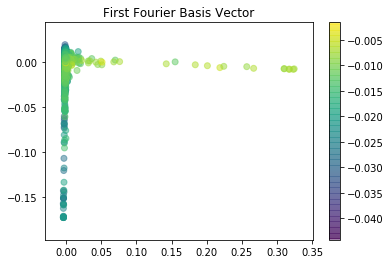

In [13]:
plt.scatter(U[:, 1], U[:, 2], c=U[:, 0], alpha=0.5)
plt.colorbar()
plt.title('First Fourier Basis Vector')

Text(0.5,1,'Second Fourier Basis Vector')

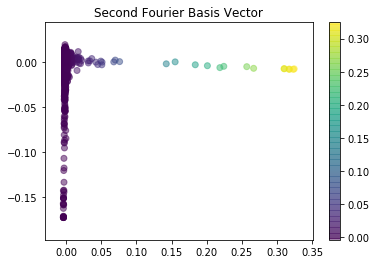

In [14]:
plt.scatter(U[:, 1], U[:, 2], c=U[:, 1], alpha=0.5)
plt.colorbar()
plt.title('Second Fourier Basis Vector')

Text(0.5,1,'Third Fourier Basis Vector')

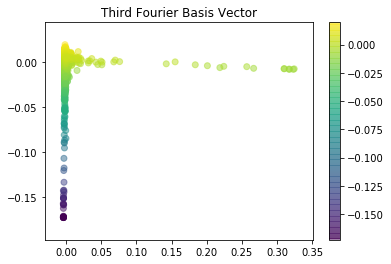

In [15]:
plt.scatter(U[:, 1], U[:, 2], c=U[:, 2], alpha=0.5)
plt.colorbar()
plt.title('Third Fourier Basis Vector')

Text(0.5,1,'Last Fourier Basis Vector')

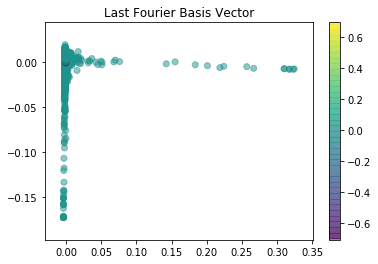

In [16]:
plt.scatter(U[:, 1], U[:, 2], c=U[:, len(U)-1], alpha=0.5)
plt.colorbar()
plt.title('Last Fourier Basis Vector')

### Question 2

What can you observe in terms of local variations when comparing the basis vectors corresponding to the smallest eigenvalues to those corresponding to the largest eigenvalue? How would this justify the interpretation of the eigenvalues as "graph frequencies"?

**Answer:** Eigenvectors associated with smaller eigenvalues have values that vary less rapidly comparing to the eigenvector associated with the heighest eigenvalue.

When looking at the biggest eigenvalue, we see that there is no signal variation. Indeed, when looking at the colormap, we see that (almost) all points are represented in green, corresponding to values near 0. The lack of variation can even be visualized in 3-D as follows. Indeed, we see that only 2 points around the center of the graph (the most crowded "area"), are out of crowd.

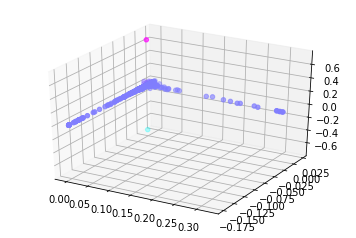

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(U[:,1], U[:,2], U[:,len(U)-1], c=U[:,len(U)-1], cmap='cool')

However, this is much different when looking at the 3 smallest eigenvalues. When looking at the 3-D representation of these eigenvalues, where we define the signal as the third dimension, we have an even better view of the variations of the data.

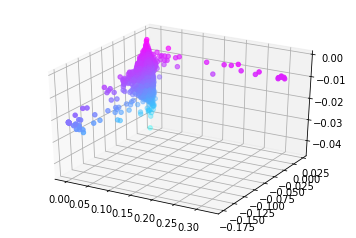

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(U[:,1], U[:,2], U[:,0], c=U[:,0], cmap='cool')

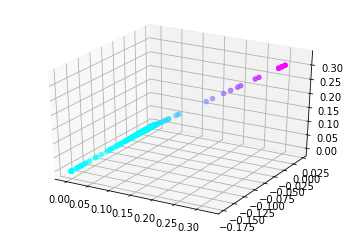

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(U[:,1], U[:,2], U[:,1], c=U[:,1], cmap='cool')

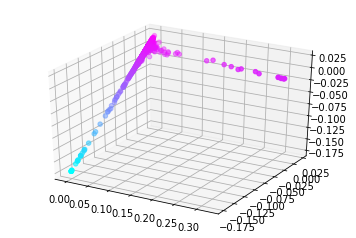

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(U[:,1], U[:,2], U[:,2], c=U[:,2], cmap='cool')

In the first case, we see that the variation differentiates between the two branches. Indeed, we see that the first dimension is below $-0.02$ while the second dimension is between $0$ and $-0.01$. However, we can still see an intermediary level above the lowest values of the first dimension. This shows even more variability on the first dimension.

On the other hand, when looking at the second and third smallest eigenvalues, we see very clear hyperplanes following an affine function across the figure. This was to be expected given the nature of the axes (respectively the second and third eigenvectors).

As a **conclusion**, it becomes very clear from these graphic representations that eigenvalues can be interpreted as graph frequencies differentiating between the different levels of the graph.

### Question 3

Implement a function that returns the Graph Fourier Transform (GFT) of a given vector $x \in \mathbb{R}^{N},$ with respect to your graph, and a function that computes the corresponding inverse GFT (iGFT).

In [21]:
def GFT(x):
    Graph_Fourier_Transform = np.matmul(np.transpose(U),x)
    return Graph_Fourier_Transform

def iGFT(x):
    inverse_GFT = np.matmul(U,x) 
    return inverse_GFT 

In [22]:
#Verifying the GFT and iGFT functions
np.allclose(iGFT(GFT(labels['gender'].values)), labels['gender'].values, atol=1e-8)

True

### Question 4

Plot your feature/label vector as a signal on your graph

In [25]:
# {2: Man, 1: Woman, 0: Gender fluid}
signal = labels['gender']
signal.value_counts()

2    2457
1    1043
0     266
Name: gender, dtype: int64

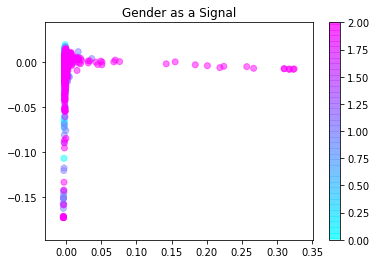

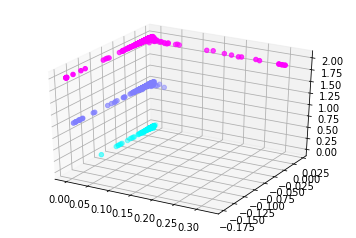

In [26]:
plotting(signal, 'Gender as a Signal')

Plot the absolute values of the GFT of your feature/label signal as a function of the graph eigenvalues. Make sure to add a marker indicating the position of each graph eigenvalue, and remember to properly name the axes.

In [27]:
lbl_gft = np.absolute(GFT(signal.values))

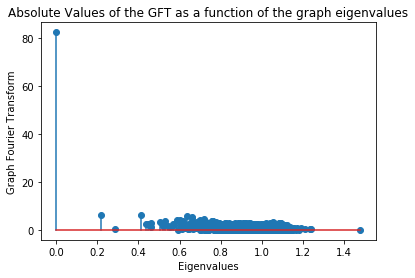

In [28]:
plt.stem(e, lbl_gft)
plt.title('Absolute Values of the GFT as a function of the graph eigenvalues')
plt.ylabel('Graph Fourier Transform')
plt.xlabel('Eigenvalues')
plt.show()

### Question 5

Discuss the behavior of the GFT that you plotted in the last question via comparing the plot of your label signal and those of the Fourier basis of Question 1. Would you consider your labels a "low-pass" or "high-pass" signal, or yet something else entirely?

**Answer:** When looking at the shape (and the magnitudes) of the transform of the eigenvalues, we see clearly that the labels resemble a "low-pass" signal given that there is a very high value in the beginning, and a lot of smaller values in the middle.

## 2 - Filtering on graphs

In this section we will check how filtered Dirac impulses diffuse on your graph.

### Question 6 

Implement the following three filter kernels and the graph filtering operation.

- The **heat kernel** is supposed to take in a vector of eigenvalues `e` and a parameter `t` and output a vector of evaluations of the heat kernel at those eigenvalues (see the course slides for help).
- The **inverse filter** kernel is supposed to take in a vector of eigenvalues `e` and a parameter `t` and implement spectrally the  filter defined in the node domain by $f_{out}  = (I + t L)^{-1} f_{in},$ where $f_{in}, f_{out} \in \mathbb{R}^{N}$ are, repectively, the input and output signals to the filter.
- The **rectangle kernel** takes in a vector of eigenvalues `e` and parameters `l_min` and `l_max` and returns `1.0` at coordinates satisfying $(e[l] \geq l_{min}) \wedge (e[l] \leq l_{max}),$ and `0.0` otherwise.
- The **graph filtering** operation takes a graph signal $x \in \mathbb{R}^{N}$, a spectral graph `kernel` and a set of keyworded variables, and returns the corresponding filtered signal.
    - _Hint:_ Remember that you have implemented the `GFT` and `iGFT` operations in Question 3.
    - The `**kwargs` is a placeholder to collect supplementary pairs of keyword-values that are not known by the implementation before execution time.
      The `kwargs` variable is a dictionary whose keyes and values are the parameter names and values.
      This is useful to allow both `graph_filter(x, heat_kernel, tau=1.0)` and `graph_filter(x, rectangle_kernel, lambda_min=0.0, lambda_max=1.0)` to be valid calls from the same implementation.
      One can then defer the keyword-value assignment to the `kernel` call: `foo = kernel(bar, **kwargs)`.

**Explanation:** Following the information on the slides and the additional explanation on Moodle, we simply consider the **heat kernel** as the function $heat(t): (\lambda_0, ..., \lambda_{N-1}) \rightarrow (e^{-t*\lambda_0}, ..., e^{-t*\lambda_{N-1}})$.

When looking at the **inverse filter**, we see from [this article](https://math.stackexchange.com/a/17778) that $(I+tL)^-1$ has a formal power series expansion. Indeed, we have that $(I+tL)^-1=\sum_{k=0}^{\infty} (-t)^k L^k=\sum_{k=0}^{\infty} (-t)^k (U \Lambda U^T)^k=U (\sum_{k=0}^{\infty}(-t)^k \Lambda^k) U^T = U * diag(\sum_{k=0}^{\infty}(-1)^k(t\lambda_0)^k, ..., \sum_{k=0}^{\infty}(-1)^k(t\lambda_{N-1})^k) * U^T$. <br>
One of the most widely used Taylor series is $\dfrac{1}{x}=1-(x-1)+(x-1)^2-(x-1)^3$ centered around 0. Thus, we have that $inverse(t): (\lambda_1, ..., \lambda_n) \rightarrow (\dfrac{1}{1+t*\lambda_0}, ..., \dfrac{1}{1+t*\lambda_{N-1}})$

In [30]:
def heat_kernel(e, t):
    h_kernel = np.apply_along_axis(lambda x: np.exp(-t*x), 0, e)
    return h_kernel

def inverse_kernel(e, t):
    inv_kernel = np.apply_along_axis(lambda x: 1/(1+(t*x)), 0, e)
    return inv_kernel

def rectangle_kernel(e, l_min, l_max):
    # initialization of the resulting vector
    result = np.zeros(len(e))
    # assigning 1 to the appropriate coordinates
    for i in range(len(e)):
        if (e[i] >= l_min) & (e[i] <= l_max):
            result[i] = 1
    return result

def graph_filter(x, kernel, **kwargs):
    
    result = np.multiply(kernel(**kwargs), GFT(x)) #ELEMENT-WISE MULTIPLICATION
    graph_result = iGFT(result)
    return graph_result

### Question 7

Plot all three filter kernels in the spectral domain. Remember to properly name the axes and title the plots. Choose filter parameters that best approximate the behavior of the GFT of your feature/label signal (as seen in Question 4).

**Explanation:** The heat kernel and inverse label parameter approximating the behavior of the GFT best is $t=0.1$, otherwise the middle values are too shrunk.

In [85]:
heat_signal = graph_filter(signal, heat_kernel, e=e, t=0.1)

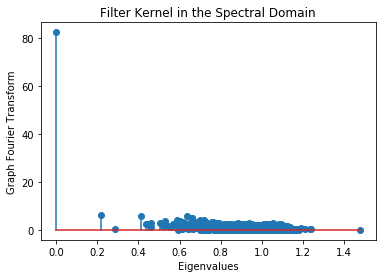

In [86]:
plt.stem(e, np.absolute(GFT(heat_signal)))
plt.title('Filter Kernel in the Spectral Domain')
plt.ylabel('Graph Fourier Transform')
plt.xlabel('Eigenvalues')
plt.show()

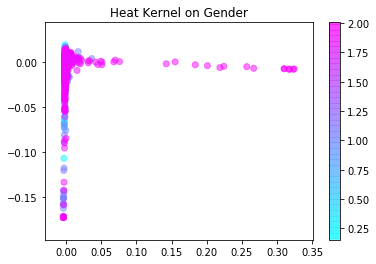

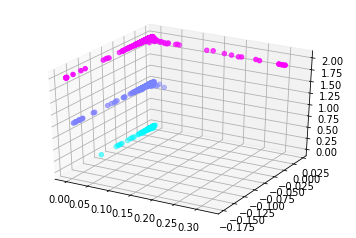

In [33]:
plotting(heat_signal, 'Heat Kernel on Gender')

In [34]:
inverse_signal = graph_filter(signal, inverse_kernel, e=e, t=0.1)

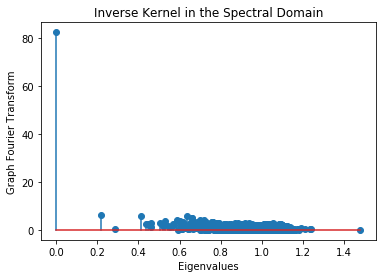

In [35]:
plt.stem(e, np.absolute(GFT(inverse_signal)))
plt.title('Inverse Kernel in the Spectral Domain')
plt.ylabel('Graph Fourier Transform')
plt.xlabel('Eigenvalues')
plt.show()

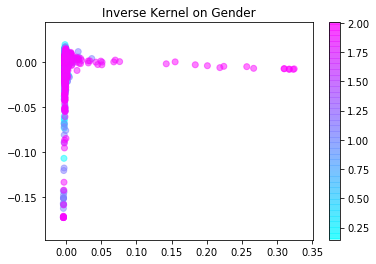

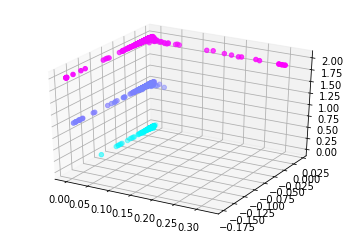

In [36]:
plotting(inverse_signal, 'Inverse Kernel on Gender')

**Explanation:** In this case, the parameters $l\_min=0$ and $l\_max=1.5$ reconstruct the signal perfectly.

In [37]:
rectangle_signal = graph_filter(signal.values, rectangle_kernel, e=e, l_min=0, l_max=1.5)

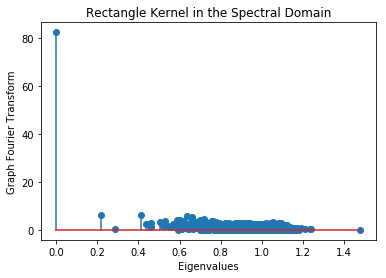

In [38]:
plt.stem(e, np.absolute(GFT(rectangle_signal)))
plt.title('Rectangle Kernel in the Spectral Domain')
plt.ylabel('Graph Fourier Transform')
plt.xlabel('Eigenvalues')
plt.show()

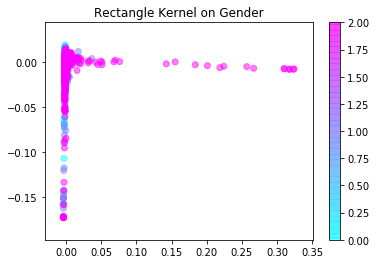

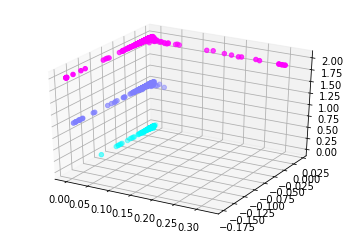

In [39]:
plotting(rectangle_signal, 'Rectangle Kernel on Gender')

### Question 8

Consider two Dirac impulses arbitrarily placed on your graph. Plot their filtered versions by the three filter kernels implemented in Question 6.

In [40]:
dirac_impulse = np.zeros(len(e))
random_1 = np.random.randint(len(e))
dirac_impulse[random_1] = 1
random_2 = np.random.randint(len(e))
dirac_impulse[random_2] = 1

In [41]:
heat_dirac_signal = graph_filter(dirac_impulse, heat_kernel, e=e, t=0.1)

In [42]:
np.count_nonzero(heat_dirac_signal == 0)

0

In [43]:
heat_dirac_signal.mean()

0.0005368468722492354

In [44]:
heat_dirac_signal.std()

0.020847980141811183

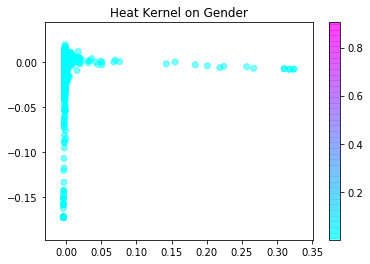

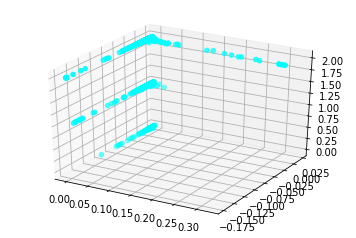

In [45]:
plotting(heat_dirac_signal, 'Heat Kernel on Gender')

In [46]:
inverse_kernel_dirac_signal = graph_filter(dirac_impulse, inverse_kernel, e=e, t=0.1)

In [47]:
np.count_nonzero(inverse_kernel_dirac_signal == 0)

0

In [48]:
inverse_kernel_dirac_signal.mean()

0.0005366041587228215

In [49]:
inverse_kernel_dirac_signal.std()

0.020946840650398497

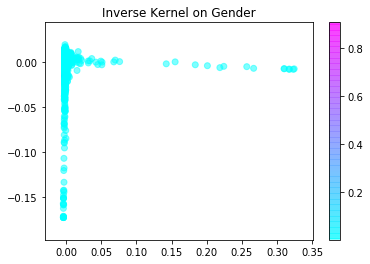

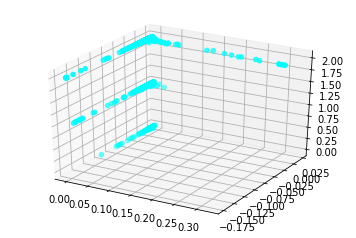

In [50]:
plotting(inverse_kernel_dirac_signal, 'Inverse Kernel on Gender')

In [51]:
rectangle_kernel_dirac_signal = graph_filter(dirac_impulse, rectangle_kernel, e=e, l_min=0, l_max=1.5)

In [52]:
np.count_nonzero(rectangle_kernel_dirac_signal == 0)

0

In [53]:
rectangle_kernel_dirac_signal.mean()

0.0005310674455655984

In [54]:
rectangle_kernel_dirac_signal.std()

0.02303878063036012

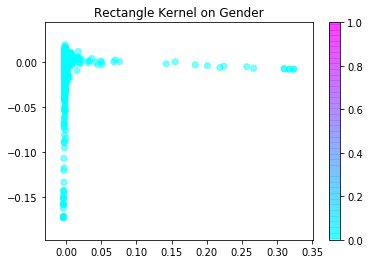

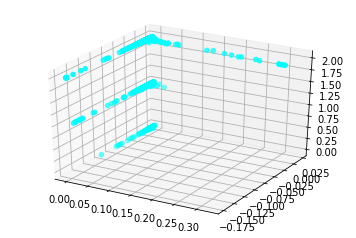

In [55]:
plotting(rectangle_kernel_dirac_signal, 'Rectangle Kernel on Gender')

Comment on the "diffusion" of the Diracs induced by the filters. What does it say about the "communication" of information across your network? Relate that to the network connectivity measures that you analyzed during the previous milestones.

**Answer:** Unfortunately, we cannot comment on the visual diffusion of the Diracs as the values are not big enough to have a good representation. However, we can see a difference simply by looking at the colorbars, but also at the differences with the statistics linked to the signals.

We can see in all cases that the Dirac is "diffused" to all values, which is a good representation of the communication of information accross our network. However, we can see that the values are really small compared to the original $1$ of the Dirac. The rectangle is the "best performing" filter, meaning it has the highest mean and standard deviation, thus showing a better communication. However, all filters have similar values, meaning they approximate the data successfully.

## 3 - De-noising

In this section we will add some centered Gaussian noise to your feature/label signal and attempt to recover it.

### Question 9

In the cell below, set the noise variance $\sigma^2$ by making sure that the signal-to-noise ratio $SNR = \frac{\operatorname{Var}(\text{labels})}{\sigma^2}$ is about  $1.5$.

_Note:_ Actually, you might want to play with the noise variance here and set it to different values and see how the denoising filters behave.

In [56]:
noise_variance = np.var(signal.values)/1.5
noisy_measurements = signal.values + np.sqrt(noise_variance) * np.random.randn(n_nodes) #signal.values=labels  
noisy_measurements

array([-0.35296378, -0.15119041,  0.14748708, ...,  1.95630515,
        2.20950573,  1.84680917])

### Question 10

In the denoising setting, a common graph signal processing assumption is that the signal $z$ that we want to recover is "smooth", in the sense that $\|\nabla_G z\|_2 = \sqrt{z^{\top} L z}$ is small, while remaining "close" to the measurements that we start with. This leads to denoising by solving the following optimization problem:

$$
z^\star = \text{arg} \, \underset{z \in \mathbb{R}^{N}}{\min} \, \|z - y\|_2^2 + \gamma z^{\top} L z, 
$$

where $y \in \mathbb{R}^{N}$ is the vector of noisy measurements.

Derive the close form solution to this problem giving $z^\star$ as a function of $y$, $\gamma$ and $L$. Does this solution correspond to any graph filtering operation that you know?

**Answer:** $\frac{d}{dz}(\|z - y\|_2^2 + \gamma z^{\top} L z) = 0$ 

$\frac{d}{dz}(\|z - y\|_2^2) + \frac{d}{dz}(\gamma z^{\top} L z) =2\frac{d}{dz}(z-y)(z-y)+2\gamma L z = 0 $

$(z-y) + \gamma L z = 0 ==> z(I+\gamma L) = y$

$z = (I+ \gamma L)^{-1}y$

This result is very similar to the the inverse filter kernel defined as $f_{out}  = (I + t L)^{-1} f_{in}$

### Question 11

Now, denoise the noisy measurements by passing them through the filters that you implemented in Question 6. Choose the filter parameters based on the behavior of the GFT of your original label signal (this is the prior knowledge that you input to the problem).

In [57]:
z_heat_denoised = graph_filter(noisy_measurements, heat_kernel, e=e, t=0.1)
z_inv_denoised = graph_filter(noisy_measurements, inverse_kernel, e=e, t=0.1)
z_rect_denoised = graph_filter(noisy_measurements, rectangle_kernel, e=e, l_min=0, l_max=1.5)

Plot, on your graph, the original label signal, the noisy measurements, and the three denoised version obtained above. Report on each plot the value of the corresponding relative error 
$$
\text{rel-err} = \frac{\|\text{labels} - z \|_2}{\|\text{labels}\|_2},
$$
where $z$ is the plotted signal.

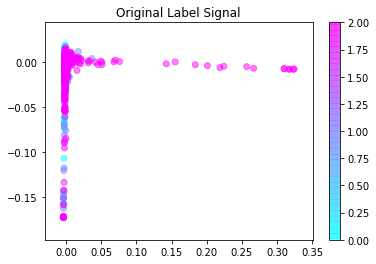

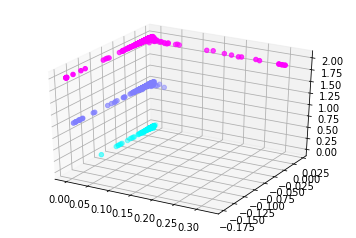

In [58]:
plotting(signal, 'Original Label Signal')

The relative error for signal with noise is  0.30029270109519685


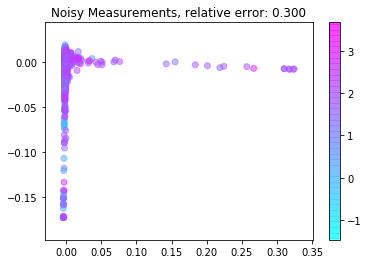

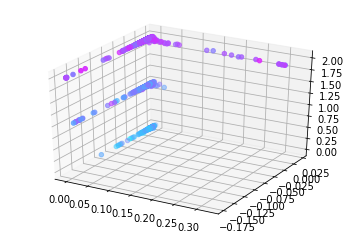

In [59]:
rel_err_noise = np.linalg.norm(signal - noisy_measurements)/np.linalg.norm(signal)
print('The relative error for signal with noise is ', rel_err_noise)
plotting(noisy_measurements, 'Noisy Measurements, relative error: %1.3f' % rel_err_noise)

The relative error for denoised signal with heat kernel filter is  0.27695845957855003


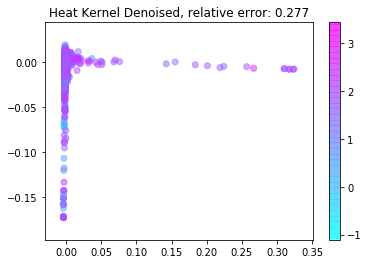

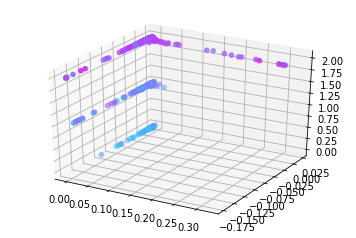

In [60]:
rel_err_heat = np.linalg.norm(signal - z_heat_denoised)/np.linalg.norm(signal)
print('The relative error for denoised signal with heat kernel filter is ', rel_err_heat)
plotting(z_heat_denoised, 'Heat Kernel Denoised, relative error: %1.3f' %rel_err_heat)

The relative error for denoised signal with inverse kernel filter is  0.2777585255007636


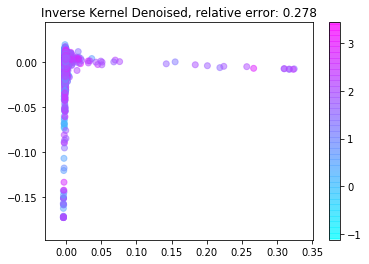

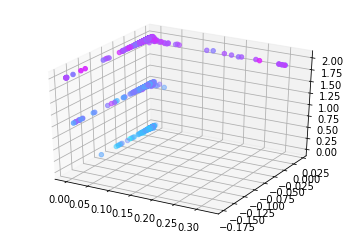

In [61]:
rel_err_inv = np.linalg.norm(signal - z_inv_denoised)/np.linalg.norm(signal)
print('The relative error for denoised signal with inverse kernel filter is ', rel_err_inv)
plotting(z_inv_denoised, 'Inverse Kernel Denoised, relative error: %1.3f' %rel_err_inv)

The relative error for denoised signal with rectangle kernel filter is  0.30029270109519685


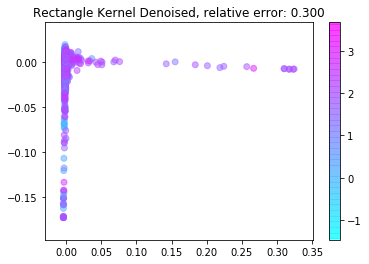

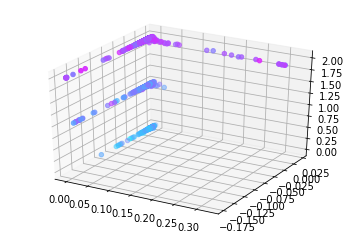

In [62]:
rel_err_rect = np.linalg.norm(signal - z_rect_denoised)/np.linalg.norm(signal)
print('The relative error for denoised signal with rectangle kernel filter is ', rel_err_rect)
plotting(z_rect_denoised, 'Rectangle Kernel Denoised, relative error: %1.3f' %rel_err_rect)

Finally, overlay on the same plot the GFT of all five signals above.

In [63]:
gft_signal = GFT(signal)
gft_noisy = GFT(noisy_measurements)
gft_heat = GFT(z_heat_denoised)
gft_inv = GFT(z_inv_denoised)
gft_rect = GFT(z_rect_denoised)

In [64]:
gft = [np.absolute(gft_signal), np.absolute(gft_noisy), np.absolute(gft_heat), np.absolute(gft_inv), np.absolute(gft_rect)]

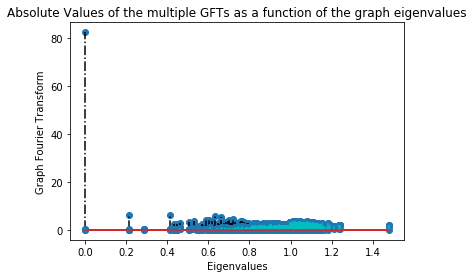

In [65]:
mkl_signal, stl_signal, b_signal = plt.stem(e, np.absolute(gft_signal), 'k-.')
mkl_noisy, stl_noisy, b_noisy = plt.stem(e, np.absolute(noisy_measurements), 'r-.')
mkl_heat, stl_heat, b_heat = plt.stem(e, np.absolute(z_heat_denoised), 'g-.')
mkl_inv, stl_inv, b_inv = plt.stem(e, np.absolute(z_inv_denoised), 'b-.')
mkl_rect, stl_rect, b_ = plt.stem(e, np.absolute(z_rect_denoised), 'c-.')

plt.title('Absolute Values of the multiple GFTs as a function of the graph eigenvalues')
plt.ylabel('Graph Fourier Transform')
plt.xlabel('Eigenvalues')
plt.show()

### Question 12

Comment on which denoised version seems to best match the original label signal. What is the underlying assumption behind the three filtering approaches? Do you think it holds for your label signal? Why?

**Answer:** The denoised version that seems to best match the original label signal is the heat kernel (even though the inverse kernel gives good results as well). The underlying assumption behind the 3 approaches has a lot to do with their original shape: the heat kernel represents a natural low-pass filter, the inverse kernel a natural high-pass filter, and the rectangle kernel a band-pass filter.

## 4 - Transductive learning

It is often the case in large networks that we can only afford to query properties/labels on a small subset of nodes. Nonetheless, if the underlying labels signal is "regular" enough, we might still be able to recover a good approximation of it by solving an offline variational problem, with constraints on the values of the measured nodes. 

In this section, we will be interested in solving such transductive learning problems by minimizing a (semi-) p-norm of the graph gradient applied to the signal of interest:

$$
\text{arg} \, \underset{z|_S = y}{\min} \|\nabla_G z\|_p^p,
$$

where $S$ is the set of measured nodes.

In English, we can say that we are looking for solutions with small "aggregated local variations", as measured by $\|\nabla_G z\|_p^p = \sum_{i=1}^{n} \sum_{j=1}^{n} \left( \sqrt{W_{ij}} |z[i] - z[j]| \right)^p,$ while satisfying the measurement constraints $z[i] = y[i]$ for $i \in S.$

We will work with two cases, according to the choices $p=1$ or $p=2.$ For $p=1,$ the problem is known as "interpolation by graph total-variation minimization," whereas for $p=2$ it is sometimes called "interpolation by Tikhonov regularization".

In order to solve these variational problems with the black-box solver provided to you, you will use the [pyunlocbox](https://pyunlocbox.readthedocs.io). This toolbox implements iterative solvers based on so-called ["proximal-splitting"](https://en.wikipedia.org/wiki/Proximal_gradient_method) methods.

### Question 13

Throughout this section, we will consider only a binarized version of your label signal. If your variable `labels` currently has values other than $\{-1, 1\},$ threshold them so that those are the only values taken in this vector. This can be done for example by choosing a number $t \in \mathbb{R}$ and then setting $\text{labels_bin}[i] = 1$ if $\text{labels}[i] \geq t$ and $\text{labels_bin}[i] = 0$ otherwise.

In [66]:
# we want to analyze women actors hence we take women as 1 and equal men and unidentified as -1
labels_bin = np.ones(len(signal))
for i in range(len(signal)):
    if (signal[i] == 0):
        labels_bin[i] = -1
    if (signal[i] == 2):
        labels_bin[i] = -1

Now, subsample this binarized label signal by $70\%$ by choosing, uniformly at random, $30\%$ of the nodes whose labels we will keep.

You will do this by computing a "measurement mask" vector `w` with `1.0`'s at the measured coordinates, and $0.0$'s otherwise.

In [67]:
mn_ratio = 0.3
m = int(mn_ratio * n_nodes)  # Number of measurements.
w = np.zeros(len(labels_bin))
rand_index = np.random.choice(range(len(labels)), m, replace=False)
for i in range(len(rand_index)):
    w[rand_index[i]] = 1

Plot the subsampled signal on the graph. _Hint:_ you might want to set to `numpy.nan` the values of the un-measured nodes for a cleaner plot.

In [68]:
w_plot = np.full(len(labels_bin), np.nan)
for i in range(len(rand_index)):
    w_plot[rand_index[i]] = labels_bin[rand_index[i]]

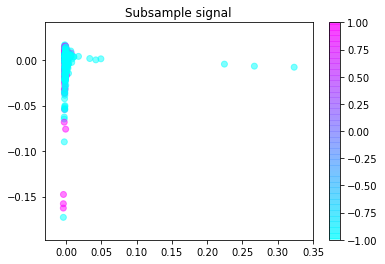

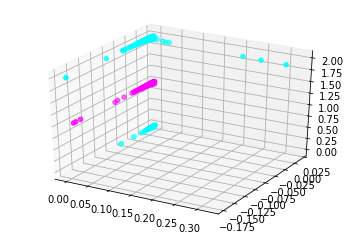

In [69]:
plotting(w_plot, 'Subsample signal')

### Interlude

For the solution of the variational problems you can use the following function as a "black-box". 

You will just need to provide a `gradient` matrix (which you should already have from Section 0), and an orthogonal projection operator `P` onto the span of the measured coordinates (made precise in the next question).

In [70]:
def graph_pnorm_interpolation(gradient, P, x0=None, p=1., **kwargs):
    r"""
    Solve an interpolation problem via gradient p-norm minimization.

    A signal :math:`x` is estimated from its measurements :math:`y = A(x)` by solving
    :math:`\text{arg}\underset{z \in \mathbb{R}^n}{\min}
    \| \nabla_G z \|_p^p \text{ subject to } Az = y` 
    via a primal-dual, forward-backward-forward algorithm.

    Parameters
    ----------
    gradient : array_like
        A matrix representing the graph gradient operator
    P : callable
        Orthogonal projection operator mapping points in :math:`z \in \mathbb{R}^n` 
        onto the set satisfying :math:`A P(z) = A z`.
    x0 : array_like, optional
        Initial point of the iteration. Must be of dimension n.
        (Default is `numpy.random.randn(n)`)
    p : {1., 2.}
    kwargs :
        Additional solver parameters, such as maximum number of iterations
        (maxit), relative tolerance on the objective (rtol), and verbosity
        level (verbosity). See :func:`pyunlocbox.solvers.solve` for the full
        list of options.

    Returns
    -------
    x : array_like
        The solution to the optimization problem.

    """
    
    grad = lambda z: gradient.dot(z)
    div = lambda z: gradient.transpose().dot(z)

    # Indicator function of the set satisfying :math:`y = A(z)`
    f = functions.func()
    f._eval = lambda z: 0
    f._prox = lambda z, gamma: P(z)

    # :math:`\ell_1` norm of the dual variable :math:`d = \nabla_G z`
    g = functions.func()
    g._eval = lambda z: np.sum(np.abs(grad(z)))
    g._prox = lambda d, gamma: functions._soft_threshold(d, gamma)

    # :math:`\ell_2` norm of the gradient (for the smooth case)
    h = functions.norm_l2(A=grad, At=div)

    stepsize = (0.9 / (1. + scipy.sparse.linalg.norm(gradient, ord='fro'))) ** p

    solver = solvers.mlfbf(L=grad, Lt=div, step=stepsize)

    if p == 1.:
        problem = solvers.solve([f, g, functions.dummy()], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    if p == 2.:
        problem = solvers.solve([f, functions.dummy(), h], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    else:
        return x0

### Question 14

During the iterations of the algorithm used for solving the variational problem, we have to make sure that the labels at the measured nodes stay the same. We will do this by means of an operator `P` which, given a vector $a \in \mathbb{R}^{N},$ returns another vector $b \in \mathbb{R}^{N}$ satisfying $b[i] = \text{labels_bin}[i]$ for every node $i$ in the set $S$ of known labels, and $b[i] = a[i]$ otherwise. Write in the cell below the function for this orthogonal projection operator `P`.

_Hint:_ remember you have already computed the mask `w`.

In [71]:
def P(a):
    b = np.zeros(len(a))
    for i in range(len(a)):
        if w[i] == 0:
            b[i] = a[i]
        else:
            b[i] = labels_bin[i]
    return b

### Question 15

Solve the variational problems for $p = 1$ and $p = 2$. Record the solution for the $1-$norm minimization under `sol_1norm_min` and the one for $2-$norm minimization under `sol_2norm_min`.

Compute also binarized versions of these solutions by thresholding the values with respect to $0$, that is, non-negative values become `1.0`, while negative values become `-1.0`. Store those binarized versions under `sol_1norm_bin` and `sol_2norm_bin`, respectively.

In [72]:
def binarize(a, threshold):
    if a < threshold:
        return -1
    else:
        return 1

In [73]:
labels_bin_1 = np.copy(labels_bin)
sol_1norm_min = graph_pnorm_interpolation(gradient, P, x0=labels_bin_1, p=1.)

labels_bin_2 = np.copy(labels_bin)
sol_2norm_min = graph_pnorm_interpolation(gradient, P, x0=labels_bin_2, p=2.)

threshold = 0

sol_1norm_bin = np.vectorize(binarize)(sol_1norm_min, threshold)

sol_2norm_bin = np.vectorize(binarize)(sol_2norm_min, threshold)

Solution found after 68 iterations:
    objective function f(sol) = 1.476799e+06
    stopping criterion: RTOL
Solution found after 200 iterations:
    objective function f(sol) = 4.137310e+05
    stopping criterion: MAXIT


Plot, on your graph, the original `labels_bin` signal, as well as the solutions to the variational problems (both binarized and otherwise). Indicate on each plot the value of the relative error $\text{rel-err} = \frac{\|\text{labels_bin} - z\|_2}{\|\text{labels_bin}\|_2}$, where $z$ is the signal in the corresponding plot.

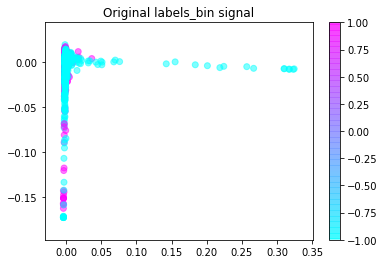

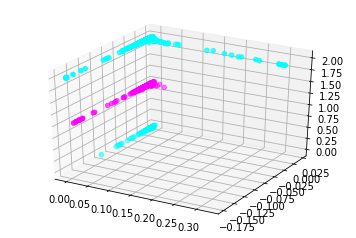

In [74]:
plotting(labels_bin, 'Original labels_bin signal')

The relative error for sol_1norm_min is  4.892199547876683


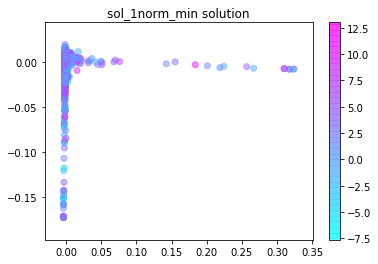

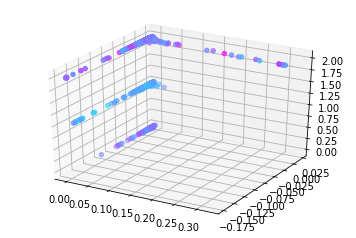

In [75]:
rel_err_1norm_min = np.linalg.norm(labels_bin - sol_1norm_min)/np.linalg.norm(labels_bin)
print('The relative error for sol_1norm_min is ', rel_err_1norm_min)
plotting(sol_1norm_min, 'sol_1norm_min solution')

The relative error for sol_2norm_min is  0.1052978797481867


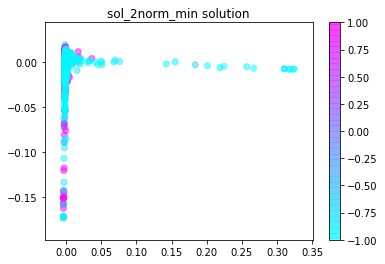

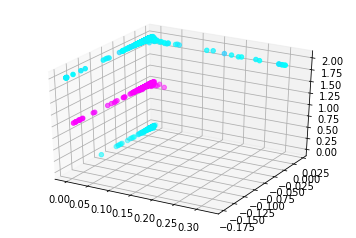

In [76]:
rel_err_2norm_min = np.linalg.norm(labels_bin - sol_2norm_min)/np.linalg.norm(labels_bin)
print('The relative error for sol_2norm_min is ', rel_err_2norm_min)
plotting(sol_2norm_min, 'sol_2norm_min solution')

The relative error for sol_1norm_bin is  1.659872858864276


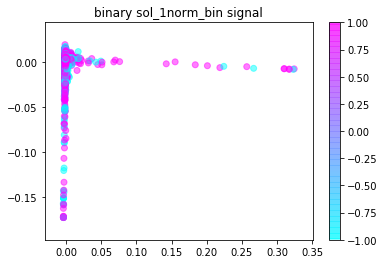

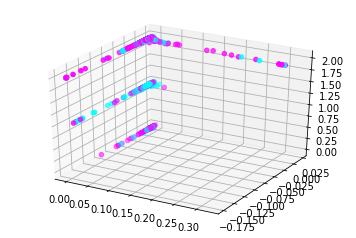

In [77]:
rel_err_1norm_bin = np.linalg.norm(labels_bin - sol_1norm_bin)/np.linalg.norm(labels_bin)
print('The relative error for sol_1norm_bin is ', rel_err_1norm_bin)
plotting(sol_1norm_bin, 'binary sol_1norm_bin signal')

The relative error for sol_2norm_bin is  0.0


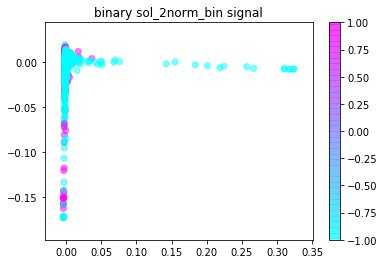

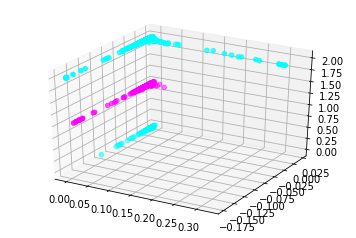

In [78]:
rel_err_2norm_bin = np.linalg.norm(labels_bin - sol_2norm_bin)/np.linalg.norm(labels_bin)
print('The relative error for sol_2norm_bin is ', rel_err_2norm_bin)
plotting(sol_2norm_bin, 'binary sol_2norm_bin signal')

### Question 16

Now that you have got a feeling for the sort of solutions that the transductive learning problems studied can give, we will see what is the effect of the number of measurements on the accuracy of both $p-$norm minimization problems.

Towards this goal, you will write a `phase_transition()` function. This function will basically go over all the procedures that you have implemented in this section, but for varying numbers of measurements and thresholding values. It will also compute the relative error, $\text{rel-err},$ of the solutions and average them over a number of trials.

The output of the `phase_transition()` function has to be a matrix with `len(mn_ratios)` columns and `len(thresholds)` rows. Each pixel $(i,j)$ in the output matrix has to contain the average, over `n_trials` trials, of the relative error $\text{rel-err}$ in the binarized (with threshold `thresholds[i]`) solution given by `graph_pnorm_interpolation()` from observing an `mn_ratios[j]` fraction of nodes. The randomness comes from a different choice of mask `w` at each trial, hence the averaging.

The interest of this phase transition matrix is to assess what level of recovery error one could expect for a certain fraction of measurements and a certain threshold level.

In [79]:
def phase_transition(mn_ratios, thresholds, n_trials, labels_bin, p):

    pt_matrix = np.zeros(shape=(len(thresholds), len(mn_ratios)))
    
    for idx_r, ratio in enumerate(mn_ratios):
        for idx_t, thresh in enumerate(thresholds):
            scores = np.zeros(n_trials)
            
            for trial in range(n_trials):
                # Create sample mask.
                w = np.zeros(len(labels_bin))
                rand_index = np.random.choice(range(len(labels_bin)), int(ratio * n_nodes), replace=False)
                for i in range(len(rand_index)):
                    w[rand_index[i]] = 1

                # Solve p-norm interpolation.

                #lbl_bins = np.copy(labels_bin)
                sol_min = graph_pnorm_interpolation(gradient, P, x0=w, p=p)
                sol_bin = np.vectorize(binarize)(sol_min, thresh)
                
                scores[trial] = np.linalg.norm(labels_bin - sol_bin)/np.linalg.norm(labels_bin)
                print(scores[trial])
            
            # Aggregate.
            pt_matrix[idx_r][idx_t] = np.mean(scores)
    
    return pt_matrix

### Question 17

Pick 5 "m/n" ratios in $(0, 1)$ and 5 threshold levels in $(-1, 1)$ and run the `phase_transition()` function with `n_trials` = 20, for both $p = 1$ and $p = 2$.

In [80]:
mn_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

thresholds = [-0.8, -0.4, 0, 0.4, 0.8]

pt_matrix_1norm = phase_transition(mn_ratios, thresholds, 20, labels_bin, 1.)

pt_matrix_2norm = phase_transition(mn_ratios, thresholds, 20, labels_bin, 2.)

Solution found after 58 iterations:
    objective function f(sol) = 5.378818e+05
    stopping criterion: RTOL
1.2834995972513783
Solution found after 60 iterations:
    objective function f(sol) = 5.141498e+05
    stopping criterion: RTOL
1.3015779467070814
Solution found after 58 iterations:
    objective function f(sol) = 5.394233e+05
    stopping criterion: RTOL
1.2872180973574876
Solution found after 60 iterations:
    objective function f(sol) = 5.314528e+05
    stopping criterion: RTOL
1.2781093312231724
Solution found after 58 iterations:
    objective function f(sol) = 5.157999e+05
    stopping criterion: RTOL
1.3032089974055376
Solution found after 58 iterations:
    objective function f(sol) = 5.296149e+05
    stopping criterion: RTOL
1.3019859009395427
Solution found after 59 iterations:
    objective function f(sol) = 5.408582e+05
    stopping criterion: RTOL
1.2768621922064853
Solution found after 59 iterations:
    objective function f(sol) = 5.701663e+05
    stopping cri

Solution found after 60 iterations:
    objective function f(sol) = 5.166938e+05
    stopping criterion: RTOL
0.8877522679325188
Solution found after 59 iterations:
    objective function f(sol) = 5.550518e+05
    stopping criterion: RTOL
0.8883502823270009
Solution found after 61 iterations:
    objective function f(sol) = 5.415889e+05
    stopping criterion: RTOL
0.8883502823270009
Solution found after 61 iterations:
    objective function f(sol) = 5.319562e+05
    stopping criterion: RTOL
0.8877522679325188
Solution found after 62 iterations:
    objective function f(sol) = 5.166452e+05
    stopping criterion: RTOL
0.8877522679325188
Solution found after 60 iterations:
    objective function f(sol) = 5.351770e+05
    stopping criterion: RTOL
0.8877522679325188
Solution found after 58 iterations:
    objective function f(sol) = 5.529129e+05
    stopping criterion: RTOL
0.8889478944244106
Solution found after 60 iterations:
    objective function f(sol) = 5.580165e+05
    stopping cri

Solution found after 61 iterations:
    objective function f(sol) = 1.256612e+06
    stopping criterion: RTOL
0.895495305852597
Solution found after 61 iterations:
    objective function f(sol) = 1.284986e+06
    stopping criterion: RTOL
0.9031719639076167
Solution found after 61 iterations:
    objective function f(sol) = 1.318782e+06
    stopping criterion: RTOL
0.8990465239078694
Solution found after 62 iterations:
    objective function f(sol) = 1.246067e+06
    stopping criterion: RTOL
0.8990465239078694
Solution found after 61 iterations:
    objective function f(sol) = 1.314319e+06
    stopping criterion: RTOL
0.8966806079013299
Solution found after 61 iterations:
    objective function f(sol) = 1.341122e+06
    stopping criterion: RTOL
0.8972726717544838
Solution found after 60 iterations:
    objective function f(sol) = 1.317829e+06
    stopping criterion: RTOL
0.8972726717544838
Solution found after 61 iterations:
    objective function f(sol) = 1.340758e+06
    stopping crit

Solution found after 61 iterations:
    objective function f(sol) = 1.315423e+06
    stopping criterion: RTOL
0.8871538504274215
Solution found after 62 iterations:
    objective function f(sol) = 1.270959e+06
    stopping criterion: RTOL
0.8877522679325188
Solution found after 61 iterations:
    objective function f(sol) = 1.289442e+06
    stopping criterion: RTOL
0.8877522679325188
Solution found after 60 iterations:
    objective function f(sol) = 1.320322e+06
    stopping criterion: RTOL
0.8871538504274215
Solution found after 61 iterations:
    objective function f(sol) = 1.311935e+06
    stopping criterion: RTOL
0.8877522679325188
Solution found after 61 iterations:
    objective function f(sol) = 1.274636e+06
    stopping criterion: RTOL
0.8877522679325188
Solution found after 61 iterations:
    objective function f(sol) = 1.290636e+06
    stopping criterion: RTOL
0.8877522679325188
Solution found after 61 iterations:
    objective function f(sol) = 1.278641e+06
    stopping cri

Solution found after 62 iterations:
    objective function f(sol) = 1.893032e+06
    stopping criterion: RTOL
0.8895451050355594
Solution found after 62 iterations:
    objective function f(sol) = 1.878729e+06
    stopping criterion: RTOL
0.8883502823270009
Solution found after 61 iterations:
    objective function f(sol) = 1.920657e+06
    stopping criterion: RTOL
0.8877522679325188
Solution found after 62 iterations:
    objective function f(sol) = 1.841268e+06
    stopping criterion: RTOL
0.8889478944244106
Solution found after 62 iterations:
    objective function f(sol) = 1.869472e+06
    stopping criterion: RTOL
0.8877522679325188
Solution found after 62 iterations:
    objective function f(sol) = 1.907420e+06
    stopping criterion: RTOL
0.8889478944244106
Solution found after 62 iterations:
    objective function f(sol) = 1.902407e+06
    stopping criterion: RTOL
0.8883502823270009
Solution found after 62 iterations:
    objective function f(sol) = 1.914793e+06
    stopping cri

Solution found after 62 iterations:
    objective function f(sol) = 2.269579e+06
    stopping criterion: RTOL
0.8925251639860807
Solution found after 62 iterations:
    objective function f(sol) = 2.288122e+06
    stopping criterion: RTOL
0.8919299487388284
Solution found after 62 iterations:
    objective function f(sol) = 2.286032e+06
    stopping criterion: RTOL
0.8925251639860807
Solution found after 62 iterations:
    objective function f(sol) = 2.284959e+06
    stopping criterion: RTOL
0.8919299487388284
Solution found after 62 iterations:
    objective function f(sol) = 2.274843e+06
    stopping criterion: RTOL
0.8919299487388284
Solution found after 62 iterations:
    objective function f(sol) = 2.266666e+06
    stopping criterion: RTOL
0.8925251639860807
Solution found after 62 iterations:
    objective function f(sol) = 2.275101e+06
    stopping criterion: RTOL
0.8919299487388284
Solution found after 62 iterations:
    objective function f(sol) = 2.305521e+06
    stopping cri

Solution found after 62 iterations:
    objective function f(sol) = 2.277951e+06
    stopping criterion: RTOL
0.8883502823270009
Solution found after 63 iterations:
    objective function f(sol) = 2.256841e+06
    stopping criterion: RTOL
0.8877522679325188
Solution found after 62 iterations:
    objective function f(sol) = 2.276311e+06
    stopping criterion: RTOL
0.8871538504274215
Solution found after 3 iterations:
    objective function f(sol) = 1.741884e+05
    stopping criterion: RTOL
0.9445598491097247
Solution found after 62 iterations:
    objective function f(sol) = 2.288929e+06
    stopping criterion: RTOL
0.8883502823270009
Solution found after 62 iterations:
    objective function f(sol) = 2.268965e+06
    stopping criterion: RTOL
0.8871538504274215
Solution found after 62 iterations:
    objective function f(sol) = 2.291860e+06
    stopping criterion: RTOL
0.8883502823270009
Solution found after 62 iterations:
    objective function f(sol) = 2.260597e+06
    stopping crit

Solution found after 63 iterations:
    objective function f(sol) = 2.461374e+06
    stopping criterion: RTOL
0.8895451050355594
Solution found after 63 iterations:
    objective function f(sol) = 2.461728e+06
    stopping criterion: RTOL
0.8901419149685378
Solution found after 63 iterations:
    objective function f(sol) = 2.464534e+06
    stopping criterion: RTOL
0.8901419149685378
Solution found after 63 iterations:
    objective function f(sol) = 2.463298e+06
    stopping criterion: RTOL
0.8901419149685378
Solution found after 63 iterations:
    objective function f(sol) = 2.467626e+06
    stopping criterion: RTOL
0.8907383250287296
Solution found after 63 iterations:
    objective function f(sol) = 2.462111e+06
    stopping criterion: RTOL
0.8895451050355594
Solution found after 63 iterations:
    objective function f(sol) = 2.463216e+06
    stopping criterion: RTOL
0.8901419149685378
Solution found after 63 iterations:
    objective function f(sol) = 2.467292e+06
    stopping cri

Solution found after 3 iterations:
    objective function f(sol) = 1.573779e+05
    stopping criterion: RTOL
1.4187126624843998
Solution found after 3 iterations:
    objective function f(sol) = 1.559384e+05
    stopping criterion: RTOL
1.4187126624843998
Solution found after 3 iterations:
    objective function f(sol) = 1.581380e+05
    stopping criterion: RTOL
1.4187126624843998
Solution found after 3 iterations:
    objective function f(sol) = 1.586847e+05
    stopping criterion: RTOL
1.4187126624843998
Solution found after 3 iterations:
    objective function f(sol) = 1.554125e+05
    stopping criterion: RTOL
1.4187126624843998
Solution found after 3 iterations:
    objective function f(sol) = 1.578727e+05
    stopping criterion: RTOL
1.4187126624843998
Solution found after 3 iterations:
    objective function f(sol) = 1.583915e+05
    stopping criterion: RTOL
1.4187126624843998
Solution found after 3 iterations:
    objective function f(sol) = 1.567580e+05
    stopping criterion: 

0.9434347029699106
Solution found after 3 iterations:
    objective function f(sol) = 1.586068e+05
    stopping criterion: RTOL
0.9546264906184758
Solution found after 3 iterations:
    objective function f(sol) = 1.571416e+05
    stopping criterion: RTOL
0.960173466360042
Solution found after 3 iterations:
    objective function f(sol) = 1.580328e+05
    stopping criterion: RTOL
0.9579585303849714
Solution found after 3 iterations:
    objective function f(sol) = 1.553557e+05
    stopping criterion: RTOL
0.9456836565852496
Solution found after 3 iterations:
    objective function f(sol) = 1.569593e+05
    stopping criterion: RTOL
0.9529561017786462
Solution found after 3 iterations:
    objective function f(sol) = 1.612510e+05
    stopping criterion: RTOL
0.9634863231248515
Solution found after 3 iterations:
    objective function f(sol) = 1.564131e+05
    stopping criterion: RTOL
0.937788723464199
Solution found after 3 iterations:
    objective function f(sol) = 1.581605e+05
    sto

Solution found after 2 iterations:
    objective function f(sol) = 2.156442e+05
    stopping criterion: RTOL
1.203641139004031
Solution found after 2 iterations:
    objective function f(sol) = 2.199776e+05
    stopping criterion: RTOL
1.1952286093343936
Solution found after 2 iterations:
    objective function f(sol) = 2.143967e+05
    stopping criterion: RTOL
1.1916687247059812
Solution found after 2 iterations:
    objective function f(sol) = 2.156415e+05
    stopping criterion: RTOL
1.1732547970948173
Solution found after 2 iterations:
    objective function f(sol) = 2.120769e+05
    stopping criterion: RTOL
1.219421521699385
Solution found after 2 iterations:
    objective function f(sol) = 2.175702e+05
    stopping criterion: RTOL
1.1795747994009695
Solution found after 2 iterations:
    objective function f(sol) = 2.146015e+05
    stopping criterion: RTOL
1.2018749735053127
Solution found after 2 iterations:
    objective function f(sol) = 2.115851e+05
    stopping criterion: RT

Solution found after 2 iterations:
    objective function f(sol) = 2.863795e+05
    stopping criterion: RTOL
1.4187126624843998
Solution found after 2 iterations:
    objective function f(sol) = 2.833948e+05
    stopping criterion: RTOL
1.4187126624843998
Solution found after 2 iterations:
    objective function f(sol) = 2.874333e+05
    stopping criterion: RTOL
1.4187126624843998
Solution found after 2 iterations:
    objective function f(sol) = 2.852759e+05
    stopping criterion: RTOL
1.4187126624843998
Solution found after 2 iterations:
    objective function f(sol) = 2.827201e+05
    stopping criterion: RTOL
1.4187126624843998
Solution found after 2 iterations:
    objective function f(sol) = 2.785730e+05
    stopping criterion: RTOL
1.4187126624843998
Solution found after 2 iterations:
    objective function f(sol) = 2.847325e+05
    stopping criterion: RTOL
1.4187126624843998
Solution found after 2 iterations:
    objective function f(sol) = 2.839608e+05
    stopping criterion: 

Solution found after 2 iterations:
    objective function f(sol) = 2.858366e+05
    stopping criterion: RTOL
1.196560835580382
Solution found after 2 iterations:
    objective function f(sol) = 2.769048e+05
    stopping criterion: RTOL
1.2005486442726936
Solution found after 2 iterations:
    objective function f(sol) = 2.830679e+05
    stopping criterion: RTOL
1.1943396329307532
Solution found after 2 iterations:
    objective function f(sol) = 2.824639e+05
    stopping criterion: RTOL
1.1863088681910816
Solution found after 2 iterations:
    objective function f(sol) = 2.820062e+05
    stopping criterion: RTOL
1.1885450791637906
Solution found after 2 iterations:
    objective function f(sol) = 2.850596e+05
    stopping criterion: RTOL
1.1863088681910816
Solution found after 2 iterations:
    objective function f(sol) = 2.851578e+05
    stopping criterion: RTOL
1.1827221362685978
Solution found after 2 iterations:
    objective function f(sol) = 2.803857e+05
    stopping criterion: R

Solution found after 2 iterations:
    objective function f(sol) = 3.752754e+05
    stopping criterion: RTOL
1.2901028541951798
Solution found after 2 iterations:
    objective function f(sol) = 3.752392e+05
    stopping criterion: RTOL
1.2933918406776805
Solution found after 2 iterations:
    objective function f(sol) = 3.749238e+05
    stopping criterion: RTOL
1.271026030186052
Solution found after 2 iterations:
    objective function f(sol) = 3.673220e+05
    stopping criterion: RTOL
1.277278040513295
Solution found after 2 iterations:
    objective function f(sol) = 3.721062e+05
    stopping criterion: RTOL
1.2830857653537113
Solution found after 2 iterations:
    objective function f(sol) = 3.696726e+05
    stopping criterion: RTOL
1.2826717999403388
Solution found after 2 iterations:
    objective function f(sol) = 3.694482e+05
    stopping criterion: RTOL
1.2651629463965022
Solution found after 2 iterations:
    objective function f(sol) = 3.684515e+05
    stopping criterion: RT

Solution found after 200 iterations:
    objective function f(sol) = 3.596378e+05
    stopping criterion: MAXIT
1.4187126624843998
Solution found after 200 iterations:
    objective function f(sol) = 3.615123e+05
    stopping criterion: MAXIT
1.4187126624843998
Solution found after 200 iterations:
    objective function f(sol) = 3.617009e+05
    stopping criterion: MAXIT
1.4187126624843998
Solution found after 200 iterations:
    objective function f(sol) = 3.637212e+05
    stopping criterion: MAXIT
1.4187126624843998
Solution found after 200 iterations:
    objective function f(sol) = 3.640483e+05
    stopping criterion: MAXIT
1.4187126624843998
Solution found after 200 iterations:
    objective function f(sol) = 3.609144e+05
    stopping criterion: MAXIT
1.4187126624843998
Solution found after 200 iterations:
    objective function f(sol) = 3.632778e+05
    stopping criterion: MAXIT
1.4187126624843998
Solution found after 200 iterations:
    objective function f(sol) = 3.665981e+05
 

Solution found after 200 iterations:
    objective function f(sol) = 3.652350e+05
    stopping criterion: MAXIT
1.376149160115604
Solution found after 200 iterations:
    objective function f(sol) = 3.624234e+05
    stopping criterion: MAXIT
1.3769207604902851
Solution found after 200 iterations:
    objective function f(sol) = 3.620193e+05
    stopping criterion: MAXIT
1.378462665520423
Solution found after 200 iterations:
    objective function f(sol) = 3.649208e+05
    stopping criterion: MAXIT
1.3792329716244214
Solution found after 200 iterations:
    objective function f(sol) = 3.667593e+05
    stopping criterion: MAXIT
1.3800028477500306
Solution found after 200 iterations:
    objective function f(sol) = 3.604317e+05
    stopping criterion: MAXIT
1.378462665520423
Solution found after 200 iterations:
    objective function f(sol) = 3.623833e+05
    stopping criterion: MAXIT
1.3660786960191833
Solution found after 200 iterations:
    objective function f(sol) = 3.630712e+05
    

Plot both phase transition matrices as images with a colorbar. Make sure to properly name the axes and title the images. 

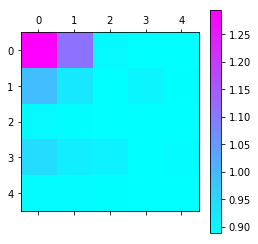

In [81]:
plt.matshow(pt_matrix_1norm, cmap='cool')
plt.colorbar()
plt.show()

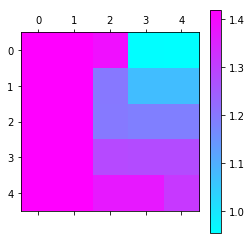

In [82]:
plt.matshow(pt_matrix_2norm, cmap='cool')
plt.colorbar()
plt.show()

### Question 18

Do the phase transition plots above provide any justification for choosing one $p-$norm interpolation over the other? Why?

**Answer:** The transition plots above clearly allow us to choose the $1-norm$ as we see that, in general, it has lower error. Moreover, the color bar shows us that the smallest error is lower using the $1-norm$ rather than the $2-norm$.